its fucked up

In [15]:
(1)
# Data Processing and Visualization
import os
import random
import glob
import re

# Data Manipulation and Analysis
import numpy as np
import pandas as pd
import math

# Image Processing and Visualization
import matplotlib.pyplot as plt
import cv2
from skimage import io
from PIL import Image

# Deep Learning Framework (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input
)
from tensorflow.keras.models import Model

# Specific TensorFlow/Keras Components
from tensorflow.keras import layers, optimizers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau, 
    EarlyStopping, 
    ModelCheckpoint, 
    LearningRateScheduler
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import categorical_crossentropy
import tensorflow.keras.backend as K

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import binary_crossentropy


Datamap imports the path of images and store them to a variable

In [16]:
(2)
datamap = []

# Specify the path to your dataset on your Windows machine
dataset_path = "Dataset_MRI"

# Iterate over subdirectories in the specified path
for sub_dir_path in glob.glob(dataset_path + "/*"):
    # Check if the current path is a directory
    if os.path.isdir(sub_dir_path):
        # Extract the tumor type from the directory name
        dir_name = os.path.basename(sub_dir_path)

        # Iterate over files in the directory
        for filename in os.listdir(sub_dir_path):
            # Construct the full path to the image file
            image_path = os.path.join(sub_dir_path, filename)
            
            # Load the image as an array
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            
            # Check if the image is successfully loaded
            if image is not None:
                # Append a dictionary to the datamap
                datamap.append({
                    'tumor_type': dir_name,
                    'file_name': filename,
                    'file_path': image_path,  # Include the full file path
                    'image': image
                })

# Display the datamap
for entry in datamap[:10]:  # Display only the first 10 entries
    print(f"Tumor Type: {entry['tumor_type']}, File Name: {entry['file_name']}, File Path: {entry['file_path']}, Image Shape: {entry['image'].shape}")


Tumor Type: Gliomas, File Name: TCGA_CS_4941_19960909_11.tif, File Path: Dataset_MRI\Gliomas\TCGA_CS_4941_19960909_11.tif, Image Shape: (256, 256, 3)
Tumor Type: Gliomas, File Name: TCGA_CS_4941_19960909_12.tif, File Path: Dataset_MRI\Gliomas\TCGA_CS_4941_19960909_12.tif, Image Shape: (256, 256, 3)
Tumor Type: Gliomas, File Name: TCGA_CS_4941_19960909_13.tif, File Path: Dataset_MRI\Gliomas\TCGA_CS_4941_19960909_13.tif, Image Shape: (256, 256, 3)
Tumor Type: Gliomas, File Name: TCGA_CS_4941_19960909_14.tif, File Path: Dataset_MRI\Gliomas\TCGA_CS_4941_19960909_14.tif, Image Shape: (256, 256, 3)
Tumor Type: Gliomas, File Name: TCGA_CS_4941_19960909_15.tif, File Path: Dataset_MRI\Gliomas\TCGA_CS_4941_19960909_15.tif, Image Shape: (256, 256, 3)
Tumor Type: Gliomas, File Name: TCGA_CS_4941_19960909_16.tif, File Path: Dataset_MRI\Gliomas\TCGA_CS_4941_19960909_16.tif, Image Shape: (256, 256, 3)
Tumor Type: Gliomas, File Name: TCGA_CS_4942_19970222_10.tif, File Path: Dataset_MRI\Gliomas\TCGA_CS

Coverting the datamap to dataframe

In [17]:
(3)
# Assume data_map is already filled with the image data as shown in the previous steps
# Convert the data_map to a pandas DataFrame
datamap_df = pd.DataFrame(datamap)

# Display the first few rows of the DataFrame to verify its structure
print(datamap_df.head())
# print(df)

  tumor_type                     file_name  \
0    Gliomas  TCGA_CS_4941_19960909_11.tif   
1    Gliomas  TCGA_CS_4941_19960909_12.tif   
2    Gliomas  TCGA_CS_4941_19960909_13.tif   
3    Gliomas  TCGA_CS_4941_19960909_14.tif   
4    Gliomas  TCGA_CS_4941_19960909_15.tif   

                                          file_path  \
0  Dataset_MRI\Gliomas\TCGA_CS_4941_19960909_11.tif   
1  Dataset_MRI\Gliomas\TCGA_CS_4941_19960909_12.tif   
2  Dataset_MRI\Gliomas\TCGA_CS_4941_19960909_13.tif   
3  Dataset_MRI\Gliomas\TCGA_CS_4941_19960909_14.tif   
4  Dataset_MRI\Gliomas\TCGA_CS_4941_19960909_15.tif   

                                               image  
0  [[[1, 1, 0], [1, 1, 0], [2, 2, 0], [2, 2, 0], ...  
1  [[[1, 4, 0], [2, 2, 0], [3, 2, 0], [2, 4, 0], ...  
2  [[[2, 3, 0], [3, 1, 0], [2, 2, 0], [1, 3, 0], ...  
3  [[[1, 2, 0], [1, 2, 0], [1, 4, 0], [1, 4, 0], ...  
4  [[[1, 5, 0], [2, 5, 0], [2, 4, 0], [2, 6, 0], ...  


Displaying the images before pre-processing

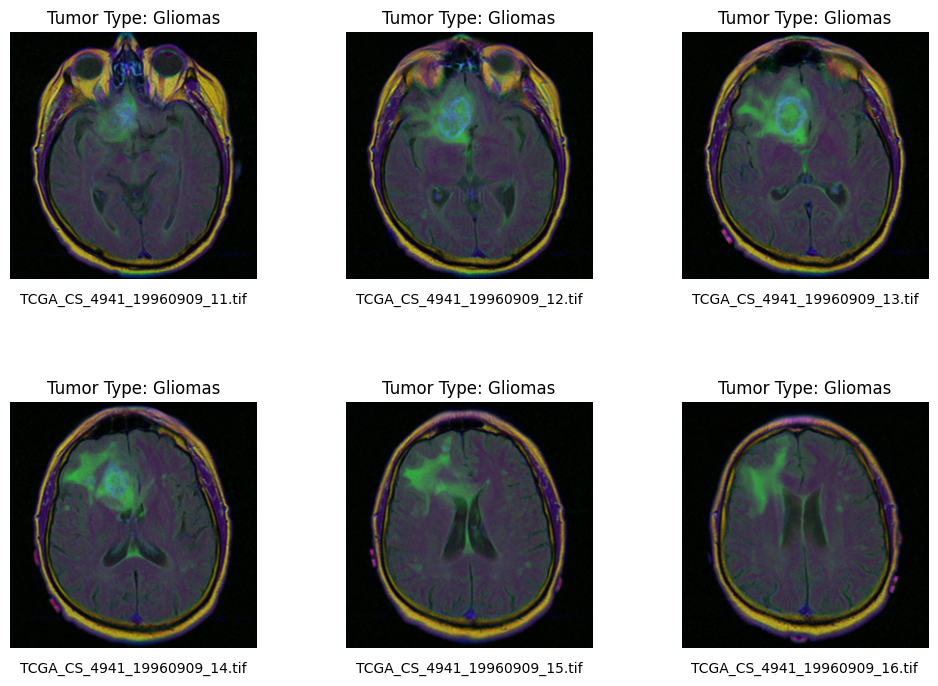

In [18]:
(4)
# Define a base directory where your images are stored
base_directory = 'Dataset_MRI'

# Initialize a counter for the number of displayed images
displayed_images = 0

# Calculate the number of rows and columns for subplots based on the number of images
num_images_to_display = 6  # Change this to the desired number of images to display
num_cols = min(num_images_to_display, 3)  # Maximum 3 columns
num_rows = math.ceil(num_images_to_display / num_cols)

# Create a new figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))

# Flatten the axes array if it's a single row or column
if num_images_to_display == 1:
    axes = [axes]
elif num_rows == 1:
    axes = axes[None, :]

# Iterate through the DataFrame to store the paths and display images
for index, row in df.iterrows():
    if displayed_images >= num_images_to_display:
        break  # Stop when the desired number of images have been displayed
    
    tumor_type = row['tumor_type']
    file_name = row['file_name']
    
    # Construct the full path
    full_path = os.path.join(base_directory, tumor_type, file_name)
    
    # Display the image using Matplotlib
    img = Image.open(full_path)
    
    # Determine the current row and column for the subplot
    current_row = displayed_images // num_cols
    current_col = displayed_images % num_cols
    
    # Display the image and file_name
    axes[current_row, current_col].imshow(img)
    axes[current_row, current_col].set_title(f'Tumor Type: {tumor_type}')
    axes[current_row, current_col].axis('off')
    
    # Display the file_name under the image
    axes[current_row, current_col].text(0.5, -0.1, file_name, transform=axes[current_row, current_col].transAxes, ha='center')
    
    displayed_images += 1

# Hide any empty subplots
for i in range(displayed_images, num_rows * num_cols):
    axes[i // num_cols, i % num_cols].axis('off')

# Adjust subplot spacing and display the figure
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

Pre-Processing

In [28]:
(5)
# Define the directory where your dataset is located
dataset_directory = 'Dataset_MRI'

# Initialize empty lists to store data and labels
data = []
labels = []

# Iterate through the dataset directory to load images and labels
for category in os.listdir(dataset_directory):
    category_dir = os.path.join(dataset_directory, category)
    if os.path.isdir(category_dir):
        for image_name in os.listdir(category_dir):
            image_path = os.path.join(category_dir, image_name)
            # Load and preprocess the image (you may need to adapt this preprocessing)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = cv2.resize(image, (128, 128))  # Adjust the size as needed
                image = image / 255.0  # Normalize
                data.append(image)
                labels.append(category)

# Convert data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

# Create DataFrames for training and validation data
train_df = pd.DataFrame({
    'file_path': X_train,  # Assuming file_path refers to image paths
    'tumor_type': y_train
})

val_df = pd.DataFrame({
    'file_path': X_val,
    'tumor_type': y_val
})

# Ensure that the file paths in the DataFrame are strings
train_df['file_path'] = train_df['file_path'].astype(str)
val_df['file_path'] = val_df['file_path'].astype(str)

ValueError: Per-column arrays must each be 1-dimensional

Images after Pre-Processing

In [21]:
# (6)
# # Define a function to display images
# def display_images(images, titles, num_cols=3):
#     num_images = len(images)
#     num_rows = math.ceil(num_images / num_cols)
    
#     plt.figure(figsize=(12, 4 * num_rows))
    
#     for i in range(num_images):
#         plt.subplot(num_rows, num_cols, i + 1)
#         plt.imshow(images[i], cmap='gray')  # Display grayscale images
#         plt.title(titles[i])
#         plt.axis('off')

# # Initialize a counter for the number of displayed images
# displayed_images = 0

# # Calculate the number of rows and columns for subplots based on the number of images
# num_images_to_display = 6  # Change this to the desired number of images to display
# num_cols = min(num_images_to_display, 3)  # Maximum 3 columns
# num_rows = math.ceil(num_images_to_display / num_cols)

# # Create a list to store grayscale images and their titles
# grayscale_images = []
# image_titles = []

# # Iterate through the DataFrame to store the paths and display images
# for index, row in df.iterrows():
#     if displayed_images >= num_images_to_display:
#         break  # Stop when the desired number of images have been displayed
    
#     tumor_type = row['tumor_type']
#     file_name = row['file_name']
#     grayscale_image = row['grayscale_image']
    
#     if grayscale_image is not None:
#         # Append the grayscale image and its title
#         grayscale_images.append(grayscale_image)
#         image_titles.append(f'Tumor Type: {tumor_type}\nFile Name: {file_name}')
    
#     displayed_images += 1

# # Display the grayscale images
# display_images(grayscale_images, image_titles, num_cols)

# # Show the plot
# plt.subplots_adjust(wspace=0.3, hspace=0.5)
# plt.show()


Split data into training, testing, validation

In [27]:
(7)
# Load your dataset and perform preprocessing
# Replace 'load_and_preprocess_data' with the actual function or code you use to load and preprocess your data.
data, labels = load_and_preprocess_data()

# Split your data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

# Create DataFrames for training and validation data
import pandas as pd

train_df = pd.DataFrame({
    'file_path': X_train,  # Assuming file_path refers to image paths
    'tumor_type': y_train
})

val_df = pd.DataFrame({
    'file_path': X_val,
    'tumor_type': y_val
})

# Ensure that the file paths in the DataFrame are strings
train_df['file_path'] = train_df['file_path'].astype(str)
val_df['file_path'] = val_df['file_path'].astype(str)



NameError: name 'load_and_preprocess_data' is not defined

Data Generator

In [24]:
(8)
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size, image_size, num_classes, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_paths = [self.image_paths[k] for k in batch_indices]
        batch_labels = [self.labels[k] for k in batch_indices]
        X, y = self.__generate_Xy(batch_image_paths, batch_labels)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __generate_Xy(self, batch_image_paths, batch_labels):
        X = np.empty((self.batch_size, *self.image_size, 1)) # Modify as per image channels
        y = np.empty((self.batch_size, self.num_classes), dtype=int)

        for i, (path, label) in enumerate(zip(batch_image_paths, batch_labels)):
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Modify if different color mode needed
            image = self.preprocess_image(image)
            X[i,] = np.expand_dims(image, axis=-1)
            y[i,] = tf.keras.utils.to_categorical(label, self.num_classes)

        return X, y

    def preprocess_image(self, image):
        grayscale = convert_to_grayscale(image)
        thresholded = apply_otsus_thresholding(grayscale)
        resized = resize_image(thresholded, self.image_size)
        normalized = normalize_image(resized)
        return normalized

# Helper preprocessing functions (add or modify as needed)
def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def apply_otsus_thresholding(image):
    _, thresholded = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresholded

def resize_image(image, size=(128, 128)):
    return cv2.resize(image, size)

def normalize_image(image):
    return image / 255.0


Train-Data & Validation-Data

In [25]:
(9)
#for single \
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# Convert the 'tumor_type' columns to numerical labels
label_encoder = LabelEncoder()
train_df['tumor_type_encoded'] = label_encoder.fit_transform(train_df['tumor_type'])
val_df['tumor_type_encoded'] = label_encoder.transform(val_df['tumor_type'])

# Define the number of classes
num_classes = len(label_encoder.classes_)

# Initialize the data generators
train_data = CustomDataGenerator(
    image_paths=train_df['file_path'].tolist(),
    labels=train_df['tumor_type_encoded'].tolist(),
    batch_size=32,
    image_size=(128, 128),  # Adjust according to your model's input size
    num_classes=num_classes,
    shuffle=True
)

val_data = CustomDataGenerator(
    image_paths=val_df['file_path'].tolist(),
    labels=val_df['tumor_type_encoded'].tolist(),
    batch_size=32,
    image_size=(128, 128),  # Adjust according to your model's input size
    num_classes=num_classes,
    shuffle=False  # Typically, we don't shuffle the validation data
)


NameError: name 'X_train_temp' is not defined

In [ ]:
(10)
# Custom VGG16 Encoder
def custom_vgg16_encoder(input_tensor):
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_tensor)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    s1 = x  # Save the feature map for decoder
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    s2 = x  # Save the feature map for decoder
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    s3 = x  # Save the feature map for decoder

    return s3, s2, s1

# Custom U-Net Decoder
def custom_unet_decoder(conv4, conv3, conv2, conv1):
    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv4)
    u6 = layers.concatenate([u6, conv3], axis=-1)
    u6 = layers.BatchNormalization()(u6)
    u6 = layers.Activation('relu')(u6)
    u6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    u6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    u6 = layers.Dropout(0.5)(u6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(u6)
    u7 = layers.concatenate([u7, conv2], axis=-1)
    u7 = layers.BatchNormalization()(u7)
    u7 = layers.Activation('relu')(u7)
    u7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    u7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    u7 = layers.Dropout(0.5)(u7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(u7)

    # Adjust the shape of conv1 to match the shape of u8
    conv1_adjusted = layers.Conv2D(128, (1, 1), activation='relu')(conv1)
    conv1_adjusted = layers.UpSampling2D(size=(2, 2))(conv1_adjusted)

    u8 = layers.concatenate([u8, conv1_adjusted], axis=-1)
    u8 = layers.BatchNormalization()(u8)
    u8 = layers.Activation('relu')(u8)
    u8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    u8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    u8 = layers.Dropout(0.5)(u8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u8)
    u9 = layers.BatchNormalization()(u9)
    u9 = layers.Activation('relu')(u9)
    u9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    u9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    u9 = layers.Dropout(0.5)(u9)
    return u9

# Build Custom UNet-VGG16 Model
def build_custom_unet_vgg16_for_grayscale(input_shape, num_classes=7):
    inputs = layers.Input(input_shape)

    """ Encoder """
    s3, s2, s1 = custom_vgg16_encoder(inputs)

    """ Decoder (U-Net) """
    u_net_decoder_output = custom_unet_decoder(s3, s2, s1, s1)

    """ Output """
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(u_net_decoder_output)

    model = tf.keras.models.Model(inputs, outputs, name="Custom_Brain_Tumor_Segmentation_Model")
    return model

# Create the model instance
custom_model = build_custom_unet_vgg16_for_grayscale((256, 256, 1), num_classes=7)

# Compile the model
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
custom_model.summary()

Model: "Custom_Brain_Tumor_Segmentation_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_23 (Conv2D)          (None, 256, 256, 64)         640       ['input_2[0][0]']             
                                                                                                  
 conv2d_24 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_23[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_24[0][0]']           
 g2D)                                                         

Custom Loss Function

In [ ]:
(11)
epsilon = 1e-5
smooth = 1

def categorical_tversky_index(y_true, y_pred, alpha=0.7):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    true_positives = K.sum(y_true * y_pred, axis=-1)
    false_negatives = K.sum(y_true * (1 - y_pred), axis=-1)
    false_positives = K.sum((1 - y_true) * y_pred, axis=-1)  # Corrected typo here

    return (true_positives + smooth) / (true_positives + alpha * false_negatives + (1 - alpha) * false_positives + smooth)

def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tversky_index = categorical_tversky_index(y_true, y_pred)
    return K.pow((1 - tversky_index), gamma)

def modified_categorical_crossentropy(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred) + (1 - categorical_tversky_index(y_true, y_pred))


Custom Scores

In [ ]:
(12)
# Custom F1 Score
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Custom Recall
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Custom Dice Coefficient for classification tasks
def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

# Custom Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Compiling the model with custom metrics
custom_model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', f1_score, recall, dice_coefficient, specificity])

# Note: Replace 'model' with your actual model variable


Checkpoints

In [ ]:
(13)
# Custom loss function and other preparations (if any)
def modified_categorical_crossentropy(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred) + (1 - categorical_tversky_index(y_true, y_pred))

# Optimizer
adam = tf.keras.optimizers.Adam(learning_rate=0.05, epsilon=0.1)

# Compile the model
custom_model.compile(optimizer=adam,
                     loss=modified_categorical_crossentropy,
                     metrics=['accuracy', f1_score, recall, dice_coefficient, specificity])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

checkpointer = ModelCheckpoint(filepath="weights_model/brain_tumor_model_weights.hdf5",
                               verbose=1,
                               save_best_only=True,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001, factor=0.2)


Epochs

In [ ]:
(14)
# Train the model
history = custom_model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[early_stopping, checkpointer, reduce_lr]
)

Unable to read image at path: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Unable to read image at path: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Unable to read image at path: [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
Unable to read image at path: [[2 1 1 ... 3 1 1]
 [2 1 1 ... 2 1 1]
 [1 2 3 ... 3 2 2]
 ...
 [2 2 1 ... 2 2 2]
 [2 2 1 ... 1 1 2]
 [2 2 2 ... 2 2 2]]
Unable to read image at path: [[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
Unable to read image at path: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Unable to read image at path: [[3 3 3 ... 1 1 2]
 [3 3 2 ... 2 3 3]
 [2 1 2 ... 1 2 3]
 ...
 [2 2 2 

ValueError: in user code:

    File "C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Implici7\AppData\Local\Temp\ipykernel_5416\1047306062.py", line 4, in modified_categorical_crossentropy  *
        return tf.keras.losses.categorical_crossentropy(y_true, y_pred) + (1 - categorical_tversky_index(y_true, y_pred))
    File "C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, None) and (None, None, None, 7) are incompatible
